# 🍎 Fruit Classification with CNN

This project builds and trains a **Convolutional Neural Network (CNN)** in PyTorch to classify fruit images.

The pipeline includes:
- Loading and transforming image data
- Designing a CNN architecture from scratch
- Training with different hyperparameters
- Applying regularization (dropout, data augmentation)
- Evaluating the trained model



## 📂 1. Load and Explore Dataset

We use `ImageFolder` from PyTorch's `torchvision.datasets` to load the image data from a directory structure.

The training and test data are organized as:
```
root/
  ├── train/
  │   ├── class1/
  │   └── class2/
  └── test/
      ├── class1/
      └── class2/
```

In [3]:
#!pip install torchvision

In [34]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [35]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="./fruit-recognition/train", transform=transform)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [36]:
# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root="./fruit-recognition/train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
CATEGORIES = ["Apple Braeburn", "Apple Granny Smith", "Apricot", "Avocado", "Banana", "Blueberry", "Cactus fruit", "Cantaloupe", "Cherry", 
              "Clementine", "Corn", "Cucumber Ripe", "Grape Blue", "Kiwi", "Lemon", "Limes", "Mango", "Onion White", "Orange", "Papaya", 
              "Passion Fruit", "Peach", "Pear", "Pepper Green", "Pepper Red", "Pineapple", "Plum", "Pomegranate", 
              "Potato Red", "Raspberry", "Strawberry", "Tomato", "Watermelon"]

## 🧼 2. Data Preprocessing & Augmentation

We resize, normalize, and augment the images to improve generalization.

- **Normalization** centers pixel values around 0
- **RandomHorizontalFlip & Rotation** augment the data


In [37]:
transform = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize RGB
])


## 🧠 3. Define CNN Architecture

We define a CNN with:
- 3 convolutional layers
- ReLU + MaxPooling
- Fully connected layers with dropout


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FruitCNN(nn.Module):
    def __init__(self, num_classes=33):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.flatten_size = 64 * 29 * 29
        self.fc1 = nn.Linear(self.flatten_size, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.flatten_size)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## ⚙️ 4. Training Setup

We define the optimizer, loss function, and training loop.

We’ll also add:
- **Learning rate scheduler**: Reduce LR over time
- **Track training and validation losses**


In [39]:
model = FruitCNN(num_classes=len(CATEGORIES))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## 🔁 5. Train the Model

Here we train for multiple epochs, tracking both training and validation losses.

We'll also apply our LR scheduler and save losses for visualization.


In [130]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(4):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    scheduler.step()
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1, Train Loss: 0.0582, Val Loss: 0.0265
Epoch 2, Train Loss: 0.0559, Val Loss: 0.0262
Epoch 3, Train Loss: 0.0553, Val Loss: 0.0266
Epoch 4, Train Loss: 0.0530, Val Loss: 0.0253


## 🧪 6. Model Tuning & Overfitting Prevention

We include:
- Dropout in the model
- Data augmentation in transforms
- Learning rate scheduling
- Visualization of loss curves


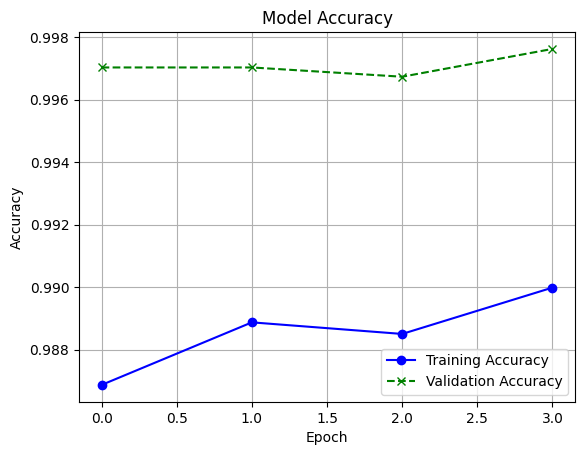

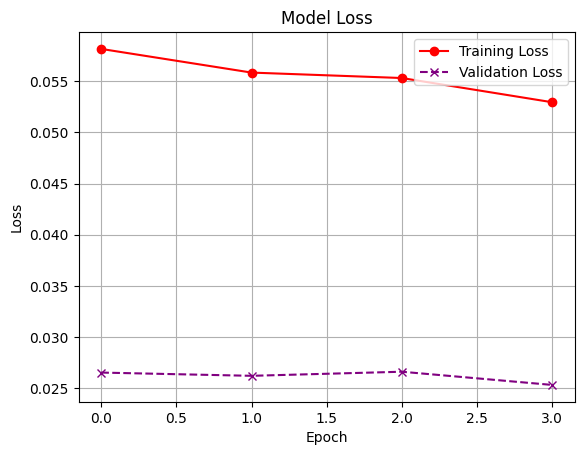

In [131]:
# Plot training & validation accuracy values
plt.plot(train_accuracies, label='Training Accuracy', linestyle='-', color='blue', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--', color='green', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.plot(train_losses, label='Training Loss', linestyle='-', color='red', marker='o')
plt.plot(val_losses, label='Validation Loss', linestyle='--', color='purple', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## 📊 7. Evaluation & Metrics

We compute classification metrics and confusion matrix.


                    precision    recall  f1-score   support

    Apple Braeburn       1.00      1.00      1.00       118
Apple Granny Smith       1.00      1.00      1.00        90
           Apricot       1.00      1.00      1.00       104
           Avocado       1.00      0.97      0.98        93
            Banana       1.00      0.98      0.99        90
         Blueberry       1.00      1.00      1.00        87
      Cactus fruit       1.00      0.99      0.99        98
        Cantaloupe       1.00      1.00      1.00       101
            Cherry       1.00      1.00      1.00        94
        Clementine       1.00      1.00      1.00        91
              Corn       1.00      1.00      1.00        88
     Cucumber Ripe       1.00      1.00      1.00        86
        Grape Blue       1.00      1.00      1.00       207
              Kiwi       1.00      1.00      1.00        93
             Lemon       1.00      1.00      1.00        96
             Limes       0.99      1.00

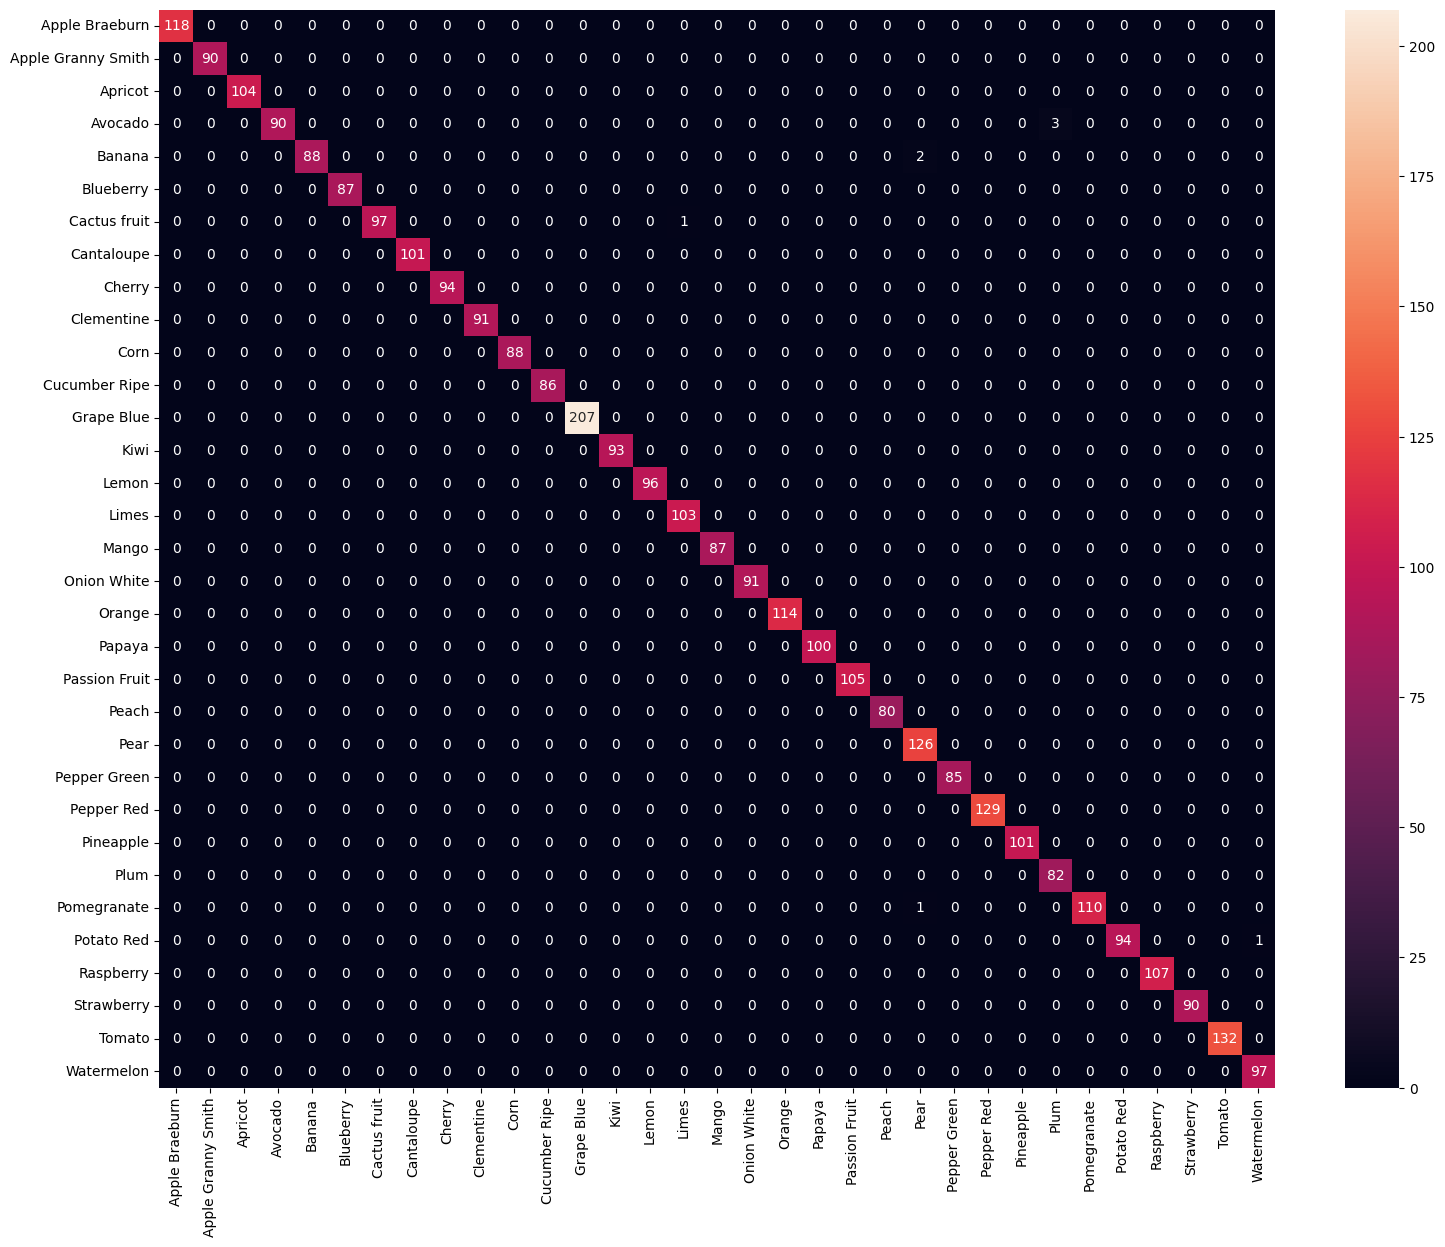

In [132]:
# Performance on Validation Set:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, labels=list(range(len(CATEGORIES))), target_names=CATEGORIES))
plt.figure(figsize=(18, 14))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.show()

## 🖼️ 8. Visualize Predictions

We visualize a few model predictions to interpret correctness.


In [60]:
from PIL import Image

In [133]:
def show_prediction(img, label):
    model.eval()
    img_tensor = transform(img).unsqueeze(0)
    pred = model(img_tensor)
    pred_label = torch.argmax(pred).item()
    plt.imshow(img)
    plt.title(f"Predicted: {CATEGORIES[pred_label]}")
    plt.axis('off')
    plt.show()

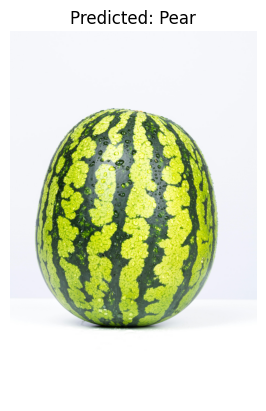

In [139]:
watermelon_img_path = "./fruit-recognition/watermelon.jpeg"
watermelon_img = Image.open(watermelon_img_path).convert("RGB")

show_prediction(watermelon_img, label=None)

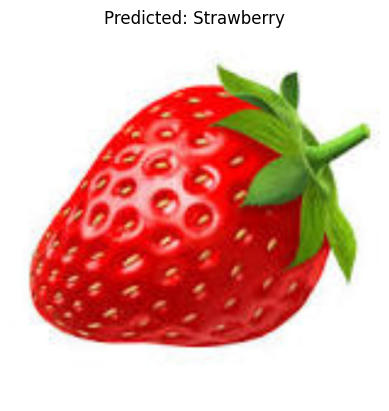

In [140]:
strawberry_img_path = "./fruit-recognition/strawberry.jpeg"
strawberry_img = Image.open(strawberry_img_path).convert("RGB")

show_prediction(strawberry_img, label=None)

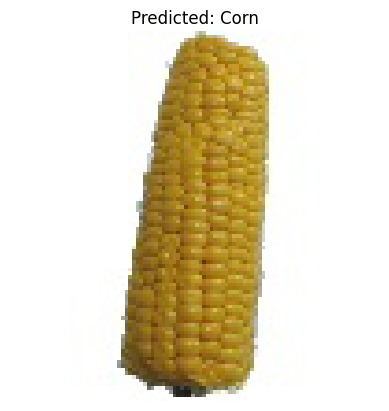

In [143]:
corn_img_path = "./fruit-recognition/corn.jpg"
corn_img = Image.open(corn_img_path).convert("RGB")

show_prediction(corn_img, label=None)

## ✅ 9. Conclusion

We built and evaluated a CNN to classify fruit images. Along the way, we:
- Used PyTorch to define and train the model
- Applied data augmentation and dropout
- Tuned learning rate and architecture
- Visualized training curves and test predictions

Use cases:
- 1. Automated Checkout in Grocery Stores
- 2. Agricultural Sorting & Packaging
- 3. Mobile Nutrition & Calorie Apps
- 4. Education & Accessibility Tools
